In [ ]:
!pip install pymorphy2
!pip install razdel

In [2]:
import pickle
import numpy as np
import pandas as pd
import pymorphy2
from razdel import sentenize
from razdel import tokenize
import torch
from transformers import AutoTokenizer, AutoModel
import re
import tqdm

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
model = AutoModel.from_pretrained("cointegrated/rubert-tiny", output_hidden_states = True)
model.eval()

In [4]:
df = pd.read_csv("/kaggle/input/newsdataset1csv/1.csv")
df.dropna(inplace=True)

In [5]:
vectors = {}

In [6]:
pm = pymorphy2.MorphAnalyzer()

In [7]:
ws353_new = pd.read_csv("/kaggle/input/ws353-full/hj-wordsim353-all.csv")
# words = set(ws353_new['word1'].values) | set(ws353_new['word2'].values)
# words_lst = set(pm.parse(word.strip())[0].normal_form for word in words)
# len(words_lst)

**Я предварительно собрал инвертированный индекс для набора слов из ws353, так как файл vocabulary слишком большой**

In [8]:
with open('/kaggle/input/ws353-full/ws353_full.pkl', 'rb') as f:
    ws_full = pickle.load(f)

Проблема заключается в слудющем, я не понимаю как перекинуть вычисления на gpu. У меня в итоге вычислений после одной итерации vector is None, хотя там должны быть вектора, количество которых равно n_contexts. 

In [ ]:
model.to('cuda')
n_contexts = 5000
i = 1
for key, value in ws_353.items():
    print(f'Iteration {i} / {len(ws_353)}')
    i += 1
    vector = None # здесь будут храниться эмбеддинги, то есть его размер будет (n_contexts, 312)
    n = 0
    for idx, n_sent, w_idx in tqdm.tqdm(value):
        if n >= n_contexts:
            break
        n += 1
        
        string_to_parse = df.iloc[idx].values[1]
        string_to_parse = re.sub(' *\n\n *', '. ', string_to_parse)
        new_str = re.sub(' +|\n *\n| *\xa0| *\n', ' ', string_to_parse)
        sent = list(sentenize(new_str))[n_sent]
        
        with torch.no_grad():
            d = tokenizer(sent.text, return_offsets_mapping=True, return_tensors='pt', return_attention_mask=False, return_token_type_ids=False)
            offset_mapping = d.pop('offset_mapping').to('cuda')
            input_ids = d['input_ids'].to('cuda')
            try:
                sent_vect = model(input_ids).last_hidden_state.to('cuda')
                word = list(tokenize(sent.text.lower()))[w_idx]
                start = np.where(offset_mapping[:, :, 0] == word.start)[1][0]
                stop = np.where(offset_mapping[:, :, 1] == word.stop)[1][0]
                if vector is None:
                    vector = sent_vect[:, start:stop+1:, ].mean(axis=1).to('cuda')
                else:
                    vector = torch.cat((vector, sent_vect[:, start:stop+1, :].mean(axis=1)), dim=0).to('cuda')
            except:
                continue
    vectors[key] = vector
    break

In [9]:
n_c = [50, 100, 200, 500, 1000, 2000]

In [10]:
from numpy.random import default_rng
rng = default_rng()

Этот кусок кода я использовал, чтобы на CPU произвести вычисления с маленькой моделью. Я решил посмотреть, как качество эмбеддингов зависит от слоя модели (здесь их всего 3). Качество на 200 контекстах получил в районе 0.57, что считаю очень хорошим результатом.

In [ ]:
for n_contexts in n_c:
    if n_contexts != 500:
        continue
    print(f'Number of contexts = {n_contexts}')
    i = 1
    contexts = {}
    for key, value in ws_full.items():
        print(f'Iteration {i} / {len(ws_full)}')
        i += 1
        vector = None # здесь будут храниться эмбеддинги, то есть его размер будет (n_contexts, 312)
        n = 0
        size = n_contexts if n_contexts <= len(value) else len(value)
        indices = rng.choice(len(value), size, replace=False)
        for index in tqdm.tqdm(indices):
            idx, n_sent, w_idx = value[index]
            if n >= n_contexts:
                break
            n += 1
            string_to_parse = df.iloc[idx].values[1]
            string_to_parse = re.sub(' *\n\n *', '. ', string_to_parse)
            new_str = re.sub(' +|\n *\n| *\xa0| *\n', ' ', string_to_parse)
            sent = list(sentenize(new_str))[n_sent]

            with torch.no_grad():
                d = tokenizer(sent.text, return_offsets_mapping=True, return_tensors='pt', return_attention_mask=False, return_token_type_ids=False)
                offset_mapping = d.pop('offset_mapping')
                input_ids = d['input_ids']
                try:
                    layers = torch.tensor(np.array([i.numpy() for i in list(model(input_ids).hidden_states)[1:]]), dtype=torch.float32)
                    word = list(tokenize(sent.text.lower()))[w_idx]
                    start = np.where(offset_mapping[:, :, 0] == word.start)[1][0]
                    stop = np.where(offset_mapping[:, :, 1] == word.stop)[1][0]
                    if vector is None:
                        vector = [layers[:, :, start:stop+1:, ]]
                    else:
                        vector.append(layers[:, :, start:stop+1, :])
                except:
                    continue
        contexts[key] = vector
    vectors[n_contexts] = contexts

Number of contexts = 500
Iteration 1 / 428


100%|██████████| 500/500 [00:05<00:00, 91.76it/s] 


Iteration 2 / 428


100%|██████████| 500/500 [00:05<00:00, 91.15it/s] 


Iteration 3 / 428


100%|██████████| 500/500 [00:05<00:00, 97.31it/s] 


Iteration 4 / 428


100%|██████████| 500/500 [00:05<00:00, 92.97it/s] 


Iteration 5 / 428


100%|██████████| 500/500 [00:05<00:00, 96.65it/s] 


Iteration 6 / 428


100%|██████████| 500/500 [00:05<00:00, 95.62it/s] 


Iteration 7 / 428


100%|██████████| 500/500 [00:05<00:00, 91.82it/s] 


Iteration 8 / 428


100%|██████████| 475/475 [00:04<00:00, 99.83it/s] 


Iteration 9 / 428


100%|██████████| 500/500 [00:05<00:00, 89.84it/s] 


Iteration 10 / 428


100%|██████████| 500/500 [00:05<00:00, 97.69it/s] 


Iteration 11 / 428


100%|██████████| 500/500 [00:05<00:00, 91.18it/s] 


Iteration 12 / 428


100%|██████████| 500/500 [00:06<00:00, 82.47it/s] 


Iteration 13 / 428


100%|██████████| 500/500 [00:06<00:00, 78.03it/s]


Iteration 14 / 428


100%|██████████| 500/500 [00:05<00:00, 96.68it/s] 


Iteration 15 / 428


100%|██████████| 500/500 [00:04<00:00, 102.29it/s]


Iteration 16 / 428


100%|██████████| 500/500 [00:06<00:00, 82.42it/s]


Iteration 17 / 428


100%|██████████| 500/500 [00:05<00:00, 99.42it/s] 


Iteration 18 / 428


100%|██████████| 500/500 [00:05<00:00, 94.76it/s] 


Iteration 19 / 428


100%|██████████| 500/500 [00:04<00:00, 103.26it/s]


Iteration 20 / 428


100%|██████████| 500/500 [00:05<00:00, 87.78it/s]


Iteration 21 / 428


100%|██████████| 500/500 [00:05<00:00, 99.68it/s] 


Iteration 22 / 428


100%|██████████| 500/500 [00:05<00:00, 94.48it/s] 


Iteration 23 / 428


100%|██████████| 500/500 [00:05<00:00, 94.76it/s] 


Iteration 24 / 428


100%|██████████| 500/500 [00:05<00:00, 95.40it/s] 


Iteration 25 / 428


100%|██████████| 500/500 [00:04<00:00, 106.04it/s]


Iteration 26 / 428


100%|██████████| 500/500 [00:05<00:00, 94.87it/s] 


Iteration 27 / 428


100%|██████████| 500/500 [00:05<00:00, 85.29it/s] 


Iteration 28 / 428


100%|██████████| 182/182 [00:01<00:00, 101.78it/s]


Iteration 29 / 428


100%|██████████| 500/500 [00:04<00:00, 101.55it/s]


Iteration 30 / 428


100%|██████████| 500/500 [00:04<00:00, 112.44it/s]


Iteration 31 / 428


100%|██████████| 500/500 [00:05<00:00, 94.70it/s] 


Iteration 32 / 428


100%|██████████| 500/500 [00:06<00:00, 83.05it/s]


Iteration 33 / 428


100%|██████████| 500/500 [00:05<00:00, 83.77it/s]


Iteration 34 / 428


100%|██████████| 500/500 [00:05<00:00, 87.79it/s] 


Iteration 35 / 428


100%|██████████| 500/500 [00:04<00:00, 102.85it/s]


Iteration 36 / 428


100%|██████████| 500/500 [00:05<00:00, 90.52it/s] 


Iteration 37 / 428


100%|██████████| 500/500 [00:05<00:00, 99.61it/s] 


Iteration 38 / 428


100%|██████████| 500/500 [00:05<00:00, 84.55it/s]


Iteration 39 / 428


100%|██████████| 500/500 [00:04<00:00, 104.32it/s]


Iteration 40 / 428


100%|██████████| 500/500 [00:05<00:00, 87.91it/s] 


Iteration 41 / 428


100%|██████████| 6/6 [00:00<00:00, 72.44it/s]


Iteration 42 / 428


100%|██████████| 500/500 [00:06<00:00, 74.68it/s]


Iteration 43 / 428


100%|██████████| 500/500 [00:04<00:00, 104.10it/s]


Iteration 44 / 428


100%|██████████| 100/100 [00:00<00:00, 101.20it/s]


Iteration 45 / 428


100%|██████████| 500/500 [00:05<00:00, 96.25it/s] 


Iteration 46 / 428


100%|██████████| 307/307 [00:03<00:00, 101.39it/s]


Iteration 47 / 428


100%|██████████| 500/500 [00:05<00:00, 99.52it/s] 


Iteration 48 / 428


100%|██████████| 500/500 [00:04<00:00, 100.21it/s]


Iteration 49 / 428


100%|██████████| 500/500 [00:05<00:00, 97.98it/s] 


Iteration 50 / 428


100%|██████████| 500/500 [00:04<00:00, 100.75it/s]


Iteration 51 / 428


100%|██████████| 500/500 [00:05<00:00, 89.11it/s]


Iteration 52 / 428


100%|██████████| 500/500 [00:04<00:00, 102.56it/s]


Iteration 53 / 428


100%|██████████| 500/500 [00:05<00:00, 91.72it/s] 


Iteration 54 / 428


100%|██████████| 500/500 [00:04<00:00, 100.37it/s]


Iteration 55 / 428


100%|██████████| 500/500 [00:06<00:00, 80.44it/s] 


Iteration 56 / 428


100%|██████████| 500/500 [00:06<00:00, 78.24it/s]


Iteration 57 / 428


100%|██████████| 500/500 [00:05<00:00, 97.53it/s] 


Iteration 58 / 428


100%|██████████| 224/224 [00:02<00:00, 89.94it/s]


Iteration 59 / 428


100%|██████████| 500/500 [00:05<00:00, 99.65it/s] 


Iteration 60 / 428


100%|██████████| 500/500 [00:05<00:00, 96.67it/s] 


Iteration 61 / 428


100%|██████████| 500/500 [00:04<00:00, 112.55it/s]


Iteration 62 / 428


100%|██████████| 500/500 [00:04<00:00, 123.16it/s]


Iteration 63 / 428


100%|██████████| 500/500 [00:06<00:00, 81.94it/s] 


Iteration 64 / 428


100%|██████████| 500/500 [00:05<00:00, 87.87it/s] 


Iteration 65 / 428


100%|██████████| 500/500 [00:05<00:00, 94.39it/s] 


Iteration 66 / 428


100%|██████████| 500/500 [00:05<00:00, 87.16it/s] 


Iteration 67 / 428


100%|██████████| 500/500 [00:05<00:00, 93.68it/s] 


Iteration 68 / 428


100%|██████████| 500/500 [00:05<00:00, 99.67it/s] 


Iteration 69 / 428


100%|██████████| 500/500 [00:06<00:00, 73.72it/s]


Iteration 70 / 428


100%|██████████| 500/500 [00:04<00:00, 101.42it/s]


Iteration 71 / 428


100%|██████████| 500/500 [00:04<00:00, 103.44it/s]


Iteration 72 / 428


100%|██████████| 500/500 [00:04<00:00, 115.39it/s]


Iteration 73 / 428


100%|██████████| 500/500 [00:05<00:00, 97.87it/s] 


Iteration 74 / 428


100%|██████████| 500/500 [00:05<00:00, 87.75it/s] 


Iteration 75 / 428


100%|██████████| 500/500 [00:04<00:00, 104.43it/s]


Iteration 76 / 428


100%|██████████| 500/500 [00:04<00:00, 108.59it/s]


Iteration 77 / 428


100%|██████████| 500/500 [00:04<00:00, 103.49it/s]


Iteration 78 / 428


100%|██████████| 500/500 [00:05<00:00, 93.50it/s] 


Iteration 79 / 428


100%|██████████| 500/500 [00:05<00:00, 86.09it/s] 


Iteration 80 / 428


100%|██████████| 500/500 [00:05<00:00, 93.52it/s] 


Iteration 81 / 428


100%|██████████| 500/500 [00:05<00:00, 90.48it/s] 


Iteration 82 / 428


100%|██████████| 500/500 [00:05<00:00, 99.17it/s] 


Iteration 83 / 428


100%|██████████| 500/500 [00:04<00:00, 111.77it/s]


Iteration 84 / 428


100%|██████████| 500/500 [00:05<00:00, 93.65it/s] 


Iteration 85 / 428


100%|██████████| 500/500 [00:05<00:00, 92.42it/s] 


Iteration 86 / 428


100%|██████████| 500/500 [00:05<00:00, 92.35it/s] 


Iteration 87 / 428


100%|██████████| 500/500 [00:05<00:00, 85.70it/s] 


Iteration 88 / 428


100%|██████████| 500/500 [00:05<00:00, 93.35it/s] 


Iteration 89 / 428


100%|██████████| 500/500 [00:09<00:00, 51.18it/s]


Iteration 90 / 428


100%|██████████| 500/500 [00:04<00:00, 102.00it/s]


Iteration 91 / 428


100%|██████████| 500/500 [00:05<00:00, 89.60it/s] 


Iteration 92 / 428


100%|██████████| 500/500 [00:05<00:00, 87.90it/s] 


Iteration 93 / 428


100%|██████████| 500/500 [00:05<00:00, 98.82it/s] 


Iteration 94 / 428


100%|██████████| 500/500 [00:05<00:00, 87.74it/s] 


Iteration 95 / 428


100%|██████████| 500/500 [00:06<00:00, 76.01it/s]


Iteration 96 / 428


100%|██████████| 500/500 [00:04<00:00, 101.22it/s]


Iteration 97 / 428


100%|██████████| 500/500 [00:05<00:00, 91.38it/s] 


Iteration 98 / 428


100%|██████████| 500/500 [00:05<00:00, 93.44it/s] 


Iteration 99 / 428


100%|██████████| 500/500 [00:05<00:00, 92.73it/s] 


Iteration 100 / 428


100%|██████████| 500/500 [00:04<00:00, 105.89it/s]


Iteration 101 / 428


100%|██████████| 361/361 [00:04<00:00, 76.36it/s]


Iteration 102 / 428


100%|██████████| 500/500 [00:05<00:00, 86.81it/s] 


Iteration 103 / 428


100%|██████████| 500/500 [00:05<00:00, 91.90it/s] 


Iteration 104 / 428


100%|██████████| 500/500 [00:05<00:00, 86.26it/s] 


Iteration 105 / 428


100%|██████████| 500/500 [00:05<00:00, 92.04it/s] 


Iteration 106 / 428


100%|██████████| 500/500 [00:05<00:00, 99.20it/s] 


Iteration 107 / 428


100%|██████████| 500/500 [00:05<00:00, 90.39it/s]


Iteration 108 / 428


100%|██████████| 500/500 [00:05<00:00, 99.17it/s] 


Iteration 109 / 428


100%|██████████| 500/500 [00:06<00:00, 81.67it/s] 


Iteration 110 / 428


100%|██████████| 500/500 [00:05<00:00, 99.93it/s] 


Iteration 111 / 428


100%|██████████| 500/500 [00:06<00:00, 83.10it/s] 


Iteration 112 / 428


100%|██████████| 500/500 [00:05<00:00, 87.59it/s]


Iteration 113 / 428


100%|██████████| 500/500 [00:06<00:00, 78.47it/s] 


Iteration 114 / 428


100%|██████████| 500/500 [00:05<00:00, 86.62it/s]


Iteration 115 / 428


100%|██████████| 500/500 [00:05<00:00, 86.31it/s] 


Iteration 116 / 428


100%|██████████| 45/45 [00:00<00:00, 104.36it/s]


Iteration 117 / 428


100%|██████████| 500/500 [00:05<00:00, 96.79it/s] 


Iteration 118 / 428


100%|██████████| 500/500 [00:04<00:00, 106.02it/s]


Iteration 119 / 428


100%|██████████| 500/500 [00:04<00:00, 109.76it/s]


Iteration 120 / 428


100%|██████████| 500/500 [00:05<00:00, 90.51it/s] 


Iteration 121 / 428


100%|██████████| 500/500 [00:04<00:00, 105.44it/s]


Iteration 122 / 428


100%|██████████| 500/500 [00:05<00:00, 92.80it/s] 


Iteration 123 / 428


100%|██████████| 42/42 [00:00<00:00, 90.71it/s]


Iteration 124 / 428


100%|██████████| 500/500 [00:05<00:00, 90.97it/s] 


Iteration 125 / 428


100%|██████████| 500/500 [00:05<00:00, 92.25it/s] 


Iteration 126 / 428


100%|██████████| 500/500 [00:05<00:00, 95.90it/s] 


Iteration 127 / 428


100%|██████████| 375/375 [00:04<00:00, 89.49it/s]


Iteration 128 / 428


100%|██████████| 500/500 [00:04<00:00, 100.95it/s]


Iteration 129 / 428


100%|██████████| 500/500 [00:05<00:00, 85.43it/s] 


Iteration 130 / 428


100%|██████████| 346/346 [00:03<00:00, 114.98it/s]


Iteration 131 / 428


100%|██████████| 500/500 [00:04<00:00, 106.25it/s]


Iteration 132 / 428


100%|██████████| 500/500 [00:05<00:00, 99.14it/s] 


Iteration 133 / 428


100%|██████████| 500/500 [00:04<00:00, 102.96it/s]


Iteration 134 / 428


100%|██████████| 500/500 [00:05<00:00, 89.00it/s]


Iteration 135 / 428


100%|██████████| 500/500 [00:05<00:00, 89.00it/s] 


Iteration 136 / 428


100%|██████████| 500/500 [00:05<00:00, 98.55it/s] 


Iteration 137 / 428


100%|██████████| 500/500 [00:05<00:00, 91.76it/s] 


Iteration 138 / 428


100%|██████████| 500/500 [00:06<00:00, 77.12it/s]


Iteration 139 / 428


100%|██████████| 500/500 [00:05<00:00, 87.33it/s] 


Iteration 140 / 428


100%|██████████| 500/500 [00:05<00:00, 98.48it/s] 


Iteration 141 / 428


100%|██████████| 500/500 [00:05<00:00, 94.94it/s] 


Iteration 142 / 428


100%|██████████| 500/500 [00:05<00:00, 98.23it/s] 


Iteration 143 / 428


100%|██████████| 500/500 [00:07<00:00, 66.73it/s]


Iteration 144 / 428


100%|██████████| 500/500 [00:05<00:00, 96.91it/s] 


Iteration 145 / 428


100%|██████████| 500/500 [00:05<00:00, 91.99it/s] 


Iteration 146 / 428


100%|██████████| 500/500 [00:05<00:00, 90.71it/s] 


Iteration 147 / 428


100%|██████████| 500/500 [00:04<00:00, 100.45it/s]


Iteration 148 / 428


100%|██████████| 500/500 [00:05<00:00, 92.93it/s] 


Iteration 149 / 428


100%|██████████| 500/500 [00:05<00:00, 94.56it/s] 


Iteration 150 / 428


100%|██████████| 500/500 [00:04<00:00, 102.45it/s]


Iteration 151 / 428


100%|██████████| 500/500 [00:05<00:00, 95.23it/s] 


Iteration 152 / 428


100%|██████████| 500/500 [00:05<00:00, 96.86it/s] 


Iteration 153 / 428


100%|██████████| 500/500 [00:05<00:00, 86.35it/s]


Iteration 154 / 428


100%|██████████| 500/500 [00:05<00:00, 92.17it/s] 


Iteration 155 / 428


100%|██████████| 500/500 [00:04<00:00, 106.94it/s]


Iteration 156 / 428


100%|██████████| 500/500 [00:05<00:00, 86.51it/s]


Iteration 157 / 428


100%|██████████| 500/500 [00:04<00:00, 102.51it/s]


Iteration 158 / 428


100%|██████████| 500/500 [00:05<00:00, 98.09it/s] 


Iteration 159 / 428


100%|██████████| 500/500 [00:06<00:00, 83.32it/s] 


Iteration 160 / 428


100%|██████████| 500/500 [00:05<00:00, 96.16it/s] 


Iteration 161 / 428


100%|██████████| 500/500 [00:07<00:00, 65.41it/s]


Iteration 162 / 428


100%|██████████| 500/500 [00:05<00:00, 87.17it/s] 


Iteration 163 / 428


100%|██████████| 500/500 [00:04<00:00, 100.57it/s]


Iteration 164 / 428


100%|██████████| 500/500 [00:04<00:00, 101.66it/s]


Iteration 165 / 428


100%|██████████| 500/500 [00:05<00:00, 90.93it/s] 


Iteration 166 / 428


100%|██████████| 500/500 [00:05<00:00, 89.26it/s] 


Iteration 167 / 428


100%|██████████| 500/500 [00:04<00:00, 102.45it/s]


Iteration 168 / 428


100%|██████████| 500/500 [00:05<00:00, 89.85it/s] 


Iteration 169 / 428


100%|██████████| 500/500 [00:05<00:00, 85.95it/s] 


Iteration 170 / 428


100%|██████████| 500/500 [00:05<00:00, 86.32it/s] 


Iteration 171 / 428


100%|██████████| 500/500 [00:05<00:00, 94.13it/s] 


Iteration 172 / 428


100%|██████████| 500/500 [00:05<00:00, 84.93it/s]


Iteration 173 / 428


100%|██████████| 500/500 [00:05<00:00, 91.25it/s] 


Iteration 174 / 428


100%|██████████| 500/500 [00:04<00:00, 100.43it/s]


Iteration 175 / 428


100%|██████████| 500/500 [00:05<00:00, 98.09it/s] 


Iteration 176 / 428


100%|██████████| 500/500 [00:05<00:00, 98.85it/s] 


Iteration 177 / 428


100%|██████████| 500/500 [00:04<00:00, 103.65it/s]


Iteration 178 / 428


100%|██████████| 500/500 [00:05<00:00, 94.36it/s] 


Iteration 179 / 428


100%|██████████| 500/500 [00:05<00:00, 89.12it/s] 


Iteration 180 / 428


100%|██████████| 500/500 [00:05<00:00, 99.26it/s] 


Iteration 181 / 428


100%|██████████| 500/500 [00:06<00:00, 75.93it/s]


Iteration 182 / 428


100%|██████████| 500/500 [00:05<00:00, 94.84it/s] 


Iteration 183 / 428


100%|██████████| 500/500 [00:05<00:00, 86.77it/s] 


Iteration 184 / 428


100%|██████████| 500/500 [00:05<00:00, 94.63it/s] 


Iteration 185 / 428


100%|██████████| 500/500 [00:05<00:00, 91.22it/s] 


Iteration 186 / 428


100%|██████████| 397/397 [00:04<00:00, 91.74it/s] 


Iteration 187 / 428


100%|██████████| 500/500 [00:05<00:00, 98.00it/s] 


Iteration 188 / 428


100%|██████████| 500/500 [00:06<00:00, 80.36it/s]


Iteration 189 / 428


100%|██████████| 500/500 [00:05<00:00, 96.10it/s] 


Iteration 190 / 428


100%|██████████| 500/500 [00:04<00:00, 107.43it/s]


Iteration 191 / 428


100%|██████████| 500/500 [00:05<00:00, 96.77it/s] 


Iteration 192 / 428


100%|██████████| 500/500 [00:05<00:00, 96.04it/s] 


Iteration 193 / 428


100%|██████████| 500/500 [00:05<00:00, 86.22it/s]


Iteration 194 / 428


100%|██████████| 500/500 [00:06<00:00, 82.89it/s] 


Iteration 195 / 428


100%|██████████| 500/500 [00:05<00:00, 87.93it/s] 


Iteration 196 / 428


100%|██████████| 500/500 [00:05<00:00, 95.91it/s] 


Iteration 197 / 428


100%|██████████| 114/114 [00:01<00:00, 88.75it/s]


Iteration 198 / 428


100%|██████████| 126/126 [00:01<00:00, 101.07it/s]


Iteration 199 / 428


100%|██████████| 500/500 [00:05<00:00, 89.41it/s] 


Iteration 200 / 428


100%|██████████| 500/500 [00:04<00:00, 103.21it/s]


Iteration 201 / 428


100%|██████████| 500/500 [00:05<00:00, 84.27it/s] 


Iteration 202 / 428


100%|██████████| 500/500 [00:05<00:00, 99.45it/s] 


Iteration 203 / 428


100%|██████████| 500/500 [00:04<00:00, 104.53it/s]


Iteration 204 / 428


100%|██████████| 500/500 [00:05<00:00, 95.26it/s] 


Iteration 205 / 428


100%|██████████| 500/500 [00:05<00:00, 97.49it/s] 


Iteration 206 / 428


100%|██████████| 500/500 [00:05<00:00, 96.34it/s] 


Iteration 207 / 428


100%|██████████| 500/500 [00:06<00:00, 82.99it/s] 


Iteration 208 / 428


100%|██████████| 500/500 [00:04<00:00, 100.78it/s]


Iteration 209 / 428


100%|██████████| 500/500 [00:04<00:00, 106.74it/s]


Iteration 210 / 428


100%|██████████| 500/500 [00:04<00:00, 111.97it/s]


Iteration 211 / 428


100%|██████████| 500/500 [00:05<00:00, 87.37it/s] 


Iteration 212 / 428


100%|██████████| 500/500 [00:05<00:00, 97.57it/s] 


Iteration 213 / 428


100%|██████████| 500/500 [00:05<00:00, 84.34it/s] 


Iteration 214 / 428


100%|██████████| 500/500 [00:05<00:00, 95.18it/s] 


Iteration 215 / 428


100%|██████████| 135/135 [00:01<00:00, 89.03it/s]


Iteration 216 / 428


100%|██████████| 500/500 [00:04<00:00, 100.90it/s]


Iteration 217 / 428


100%|██████████| 500/500 [00:05<00:00, 94.09it/s] 


Iteration 218 / 428


100%|██████████| 500/500 [00:05<00:00, 84.12it/s] 


Iteration 219 / 428


100%|██████████| 500/500 [00:05<00:00, 99.95it/s] 


Iteration 220 / 428


100%|██████████| 500/500 [00:05<00:00, 92.00it/s] 


Iteration 221 / 428


100%|██████████| 500/500 [00:05<00:00, 98.85it/s] 


Iteration 222 / 428


100%|██████████| 500/500 [00:05<00:00, 99.68it/s] 


Iteration 223 / 428


100%|██████████| 32/32 [00:00<00:00, 99.79it/s] 


Iteration 224 / 428


100%|██████████| 500/500 [00:04<00:00, 103.78it/s]


Iteration 225 / 428


100%|██████████| 500/500 [00:04<00:00, 110.67it/s]


Iteration 226 / 428


100%|██████████| 109/109 [00:01<00:00, 92.68it/s]


Iteration 227 / 428


100%|██████████| 500/500 [00:04<00:00, 105.21it/s]


Iteration 228 / 428


100%|██████████| 500/500 [00:05<00:00, 97.17it/s] 


Iteration 229 / 428


100%|██████████| 500/500 [00:05<00:00, 98.78it/s] 


Iteration 230 / 428


100%|██████████| 500/500 [00:05<00:00, 88.53it/s] 


Iteration 231 / 428


100%|██████████| 500/500 [00:05<00:00, 93.91it/s] 


Iteration 232 / 428


100%|██████████| 500/500 [00:04<00:00, 112.51it/s]


Iteration 233 / 428


100%|██████████| 500/500 [00:04<00:00, 106.98it/s]


Iteration 234 / 428


100%|██████████| 500/500 [00:05<00:00, 89.46it/s] 


Iteration 235 / 428


100%|██████████| 62/62 [00:00<00:00, 99.44it/s] 


Iteration 236 / 428


100%|██████████| 500/500 [00:04<00:00, 103.86it/s]


Iteration 237 / 428


100%|██████████| 500/500 [00:05<00:00, 85.05it/s] 


Iteration 238 / 428


100%|██████████| 289/289 [00:04<00:00, 66.91it/s] 


Iteration 239 / 428


100%|██████████| 149/149 [00:01<00:00, 105.98it/s]


Iteration 240 / 428


100%|██████████| 500/500 [00:05<00:00, 98.17it/s] 


Iteration 241 / 428


100%|██████████| 500/500 [00:04<00:00, 108.25it/s]


Iteration 242 / 428


100%|██████████| 500/500 [00:04<00:00, 101.56it/s]


Iteration 243 / 428


100%|██████████| 500/500 [00:05<00:00, 92.18it/s] 


Iteration 244 / 428


100%|██████████| 500/500 [00:04<00:00, 101.30it/s]


Iteration 245 / 428


100%|██████████| 500/500 [00:04<00:00, 110.21it/s]


Iteration 246 / 428


100%|██████████| 500/500 [00:05<00:00, 91.58it/s] 


Iteration 247 / 428


100%|██████████| 500/500 [00:05<00:00, 97.11it/s] 


Iteration 248 / 428


100%|██████████| 500/500 [00:05<00:00, 85.54it/s] 


Iteration 249 / 428


100%|██████████| 500/500 [00:06<00:00, 76.77it/s]


Iteration 250 / 428


100%|██████████| 500/500 [00:05<00:00, 96.83it/s] 


Iteration 251 / 428


100%|██████████| 500/500 [00:04<00:00, 103.80it/s]


Iteration 252 / 428


100%|██████████| 500/500 [00:05<00:00, 90.43it/s] 


Iteration 253 / 428


100%|██████████| 500/500 [00:04<00:00, 103.91it/s]


Iteration 254 / 428


100%|██████████| 500/500 [00:05<00:00, 94.68it/s] 


Iteration 255 / 428


100%|██████████| 500/500 [00:05<00:00, 88.44it/s] 


Iteration 256 / 428


100%|██████████| 500/500 [00:05<00:00, 98.59it/s] 


Iteration 257 / 428


100%|██████████| 500/500 [00:05<00:00, 95.22it/s] 


Iteration 258 / 428


100%|██████████| 500/500 [00:04<00:00, 100.55it/s]


Iteration 259 / 428


100%|██████████| 500/500 [00:04<00:00, 104.30it/s]


Iteration 260 / 428


100%|██████████| 500/500 [00:05<00:00, 93.61it/s] 


Iteration 261 / 428


100%|██████████| 500/500 [00:05<00:00, 95.08it/s] 


Iteration 262 / 428


100%|██████████| 500/500 [00:05<00:00, 94.68it/s] 


Iteration 263 / 428


100%|██████████| 500/500 [00:04<00:00, 104.73it/s]


Iteration 264 / 428


100%|██████████| 500/500 [00:05<00:00, 92.46it/s] 


Iteration 265 / 428


100%|██████████| 500/500 [00:05<00:00, 88.27it/s]


Iteration 266 / 428


100%|██████████| 500/500 [00:06<00:00, 82.31it/s] 


Iteration 267 / 428


100%|██████████| 500/500 [00:04<00:00, 124.28it/s]


Iteration 268 / 428


100%|██████████| 58/58 [00:00<00:00, 91.11it/s]


Iteration 269 / 428


100%|██████████| 500/500 [00:06<00:00, 81.60it/s] 


Iteration 270 / 428


100%|██████████| 500/500 [00:04<00:00, 101.93it/s]


Iteration 271 / 428


100%|██████████| 500/500 [00:05<00:00, 92.23it/s] 


Iteration 272 / 428


100%|██████████| 444/444 [00:05<00:00, 82.00it/s] 


Iteration 273 / 428


100%|██████████| 432/432 [00:04<00:00, 92.32it/s] 


Iteration 274 / 428


100%|██████████| 500/500 [00:05<00:00, 96.60it/s] 


Iteration 275 / 428


100%|██████████| 500/500 [00:05<00:00, 84.60it/s]


Iteration 276 / 428


100%|██████████| 500/500 [00:05<00:00, 99.50it/s] 


Iteration 277 / 428


100%|██████████| 500/500 [00:05<00:00, 86.17it/s]


Iteration 278 / 428


100%|██████████| 500/500 [00:04<00:00, 103.63it/s]


Iteration 279 / 428


100%|██████████| 169/169 [00:02<00:00, 82.54it/s]


Iteration 280 / 428


100%|██████████| 500/500 [00:05<00:00, 84.27it/s] 


Iteration 281 / 428


100%|██████████| 500/500 [00:06<00:00, 77.88it/s]


Iteration 282 / 428


100%|██████████| 500/500 [00:04<00:00, 100.94it/s]


Iteration 283 / 428


100%|██████████| 500/500 [00:04<00:00, 100.62it/s]


Iteration 284 / 428


100%|██████████| 500/500 [00:05<00:00, 94.67it/s] 


Iteration 285 / 428


100%|██████████| 500/500 [00:05<00:00, 92.83it/s] 


Iteration 286 / 428


100%|██████████| 500/500 [00:05<00:00, 93.21it/s] 


Iteration 287 / 428


100%|██████████| 500/500 [00:05<00:00, 85.01it/s] 


Iteration 288 / 428


 87%|████████▋ | 434/500 [02:48<03:23,  3.09s/it] 

In [12]:
from itertools import product

In [13]:
def g_pooling(collection, func, axis=0):
    if func == torch.mean:
        return torch.stack(tuple(func(vector[:, 0, ...], axis=axis) for vector in collection), dim=0)
    return torch.stack(tuple(func(vector[:, 0, ...], axis=axis).values for vector in collection), dim=0)
def f_pooling(collection, func, axis=0):
    if func == torch.mean:
        return func(collection, axis=axis)
    return func(collection, axis=axis).values
    

In [14]:
funcs = {'mean': torch.mean, 'min': torch.min, 'max': torch.max}

In [15]:
n_500 ={}
keys = list(product(['mean', 'max', 'min'], repeat=2))
for key in tqdm.tqdm(keys):
    f, g = key
    stats = {}
    print(key)
    for word, lst in vectors[500].items():
        stats[word] = f_pooling(g_pooling(lst, funcs[g], 1), funcs[f])
    n_500[key] = stats
    

  0%|          | 0/9 [00:00<?, ?it/s]

('mean', 'mean')


 11%|█         | 1/9 [00:02<00:19,  2.41s/it]

('mean', 'max')


 22%|██▏       | 2/9 [00:05<00:18,  2.59s/it]

('mean', 'min')


 33%|███▎      | 3/9 [00:07<00:16,  2.69s/it]

('max', 'mean')


 44%|████▍     | 4/9 [00:10<00:13,  2.66s/it]

('max', 'max')


 56%|█████▌    | 5/9 [00:13<00:10,  2.72s/it]

('max', 'min')


 67%|██████▋   | 6/9 [00:16<00:08,  2.75s/it]

('min', 'mean')


 78%|███████▊  | 7/9 [00:18<00:05,  2.76s/it]

('min', 'max')


 89%|████████▉ | 8/9 [00:22<00:02,  2.92s/it]

('min', 'min')


100%|██████████| 9/9 [00:25<00:00,  2.80s/it]


In [16]:
with open('n_200.pkl', 'wb') as f:
    pickle.dump(n_200, f)

In [17]:
def cosine_sim(x, y):
    return (x @ y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [18]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

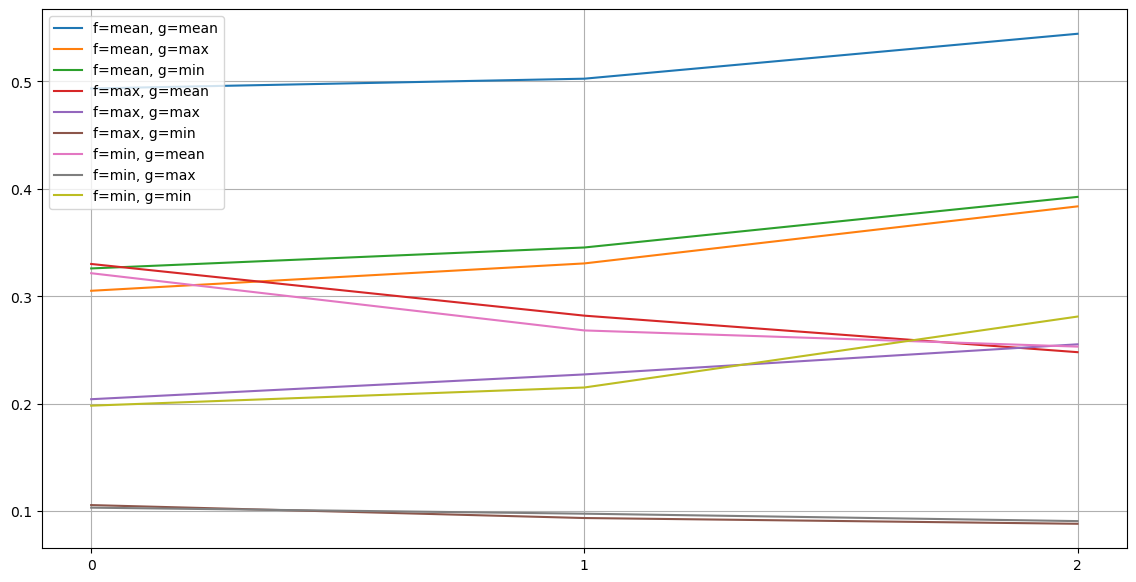

In [19]:
score = ws353_new['sim']
res = {}
for key in keys:
    my_score = [[], [], []]
    for idx in range(ws353_new.shape[0]):
        w1 = pm.parse(ws353_new.iloc[idx].word1)[0].normal_form
        w2 = pm.parse(ws353_new.iloc[idx].word2)[0].normal_form
        for i in range(3):
            my_score[i].append(cosine_sim(n_200[(key[0], key[1])][w1][i], n_200[(key[0], key[1])][w2][i]))
    res[key] = my_score
plt.figure(figsize=(14, 7))
plt.xticks(np.arange(0, 3))
plt.grid()
for key in keys:
    plt.plot(range(3), [spearmanr(res[key][i], score).correlation for i in range(3)], label=f'f={key[0]}, g={key[1]}')
plt.legend()

In [104]:
score = ws353_new['sim']
res = {}
for key in keys:
    my_score = [[], [], []]
    for idx in range(ws353_new.shape[0]):
        w1 = pm.parse(ws353_new.iloc[idx].word1)[0].normal_form
        w2 = pm.parse(ws353_new.iloc[idx].word2)[0].normal_form
        for i in range(3):
            my_score[i].append(cosine_sim(n_100[(key[0], key[1])][w1][i], n_50[(key[0], key[1])][w2][i]))
    res[key] = my_score

In [109]:
[spearmanr(res[('mean','mean')][i], score).correlation for i in range(3)]

[0.501180824059812, 0.5099989779490852, 0.5512898762175672]

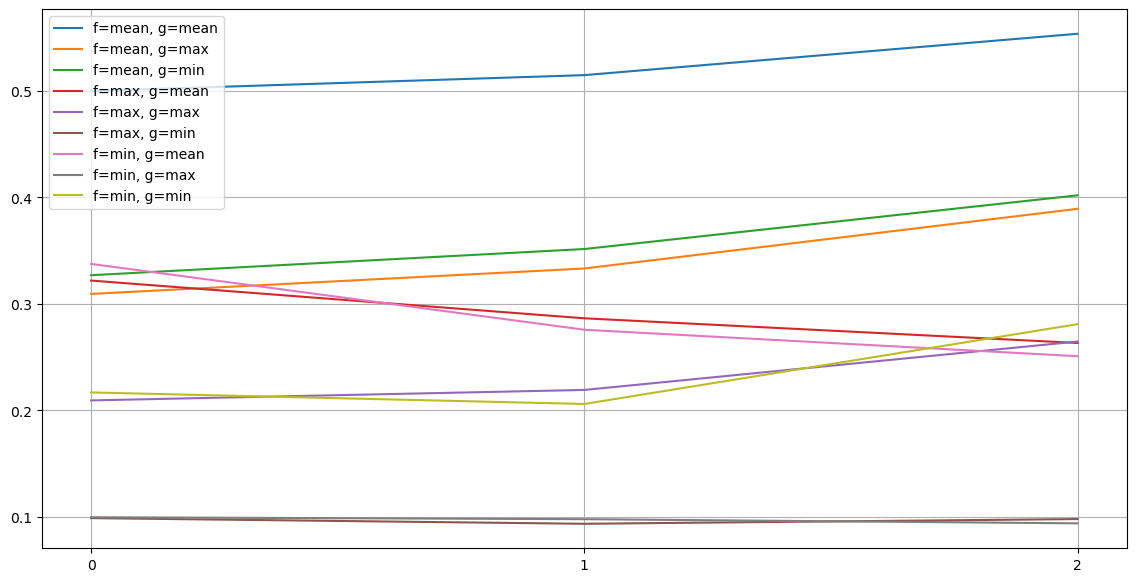

In [105]:
plt.figure(figsize=(14, 7))
plt.xticks(np.arange(0, 3))
plt.grid()
for key in keys:
    plt.plot(range(3), [spearmanr(res[key][i], score).correlation for i in range(3)], label=f'f={key[0]}, g={key[1]}')
plt.legend()

In [108]:
score = ws353_new['sim']
res = {}
for key in keys:
    my_score = [[], [], []]
    for idx in range(ws353_new.shape[0]):
        w1 = pm.parse(ws353_new.iloc[idx].word1)[0].normal_form
        w2 = pm.parse(ws353_new.iloc[idx].word2)[0].normal_form
        for i in range(3):
            my_score[i].append(cosine_sim(n_50[(key[0], key[1])][w1][i], n_50[(key[0], key[1])][w2][i]))
    res[key] = my_score

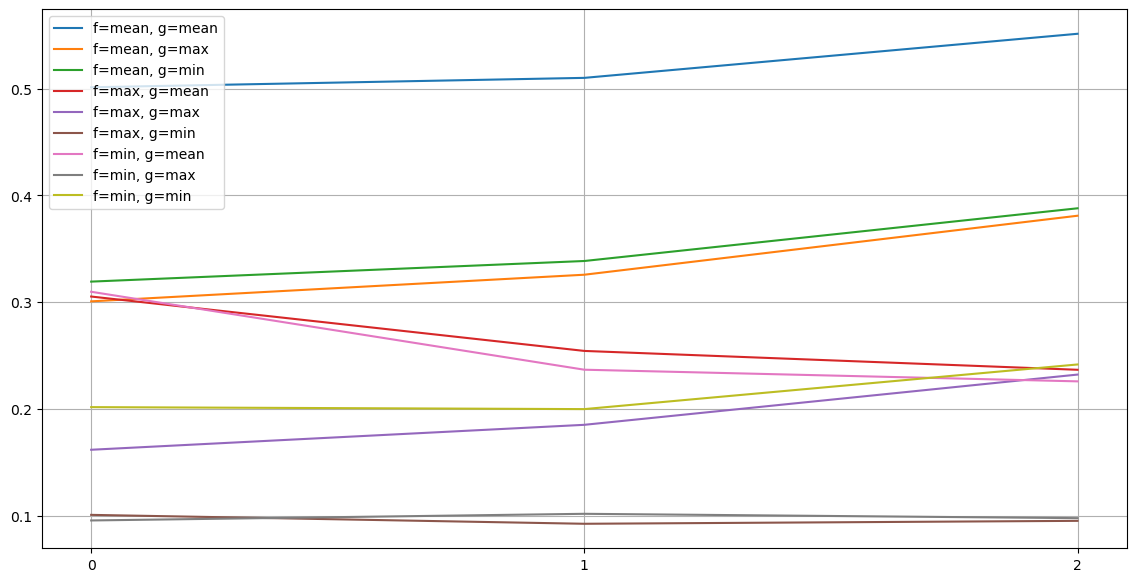

In [95]:
plt.figure(figsize=(14, 7))
plt.xticks(np.arange(0, 3))
plt.grid()
for key in keys:
    plt.plot(range(3), [spearmanr(res[key][i], score).correlation for i in range(3)], label=f'f={key[0]}, g={key[1]}')
plt.legend()